In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, FloatType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
from tsfresh.convenience.bindings import spark_feature_extraction_on_chunk
from tsfresh.feature_extraction.settings import MinimalFCParameters

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[18]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

### Load data

In [5]:
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("bigram_percent", DoubleType(), True),
    StructField("ntileA", IntegerType(), True),
    StructField("ntileB", IntegerType(), True),
    StructField("label", IntegerType(), True),
    StructField("peak_year", IntegerType(), True),
    StructField('changepoint_prob', FloatType(), True),
    StructField('changepoint_year', IntegerType(), True)])

In [6]:
# Years for 1990-1995:
#df_allyears = spark.read.option('header', False).schema(schema).csv('/data/shared1/cleandata/online_changepoints_newest_7')

# Years for 2013-2017 - 1 år vent og 9: 50 % chance, 10: 1 år vent og 75 % chance, 11: 3 år vent og 50 %, 
# 12: 2 år vent og 50 %, 13: 2 år vent og 75 %
df_allyears = spark.read.option('header', False).schema(schema).csv('/data/shared1/cleandata/online_changepoints_newest_12')

In [7]:
# only take the bigrams which peak years is after the online change point

df_allyears = df_allyears.where(col('peak_year') > col('changepoint_year'))

In [8]:
#df_allyears = df_allyears.where((col('changepoint_year') >= 1995) & (col('changepoint_year') <= 2000))
df_allyears = df_allyears.where((col('changepoint_year') >= 2013) & (col('changepoint_year') <= 2019))

In [20]:
df_allyears.select('bigram').distinct().count()

118

### Run classification

In [9]:
# Filter the years that we want to look at
def filter_classify(df, yearlag, yearsBeforeBreak):
    df = df.where((col('year') <= col('changepoint_year') - yearsBeforeBreak) 
                  & (col('year') > col('changepoint_year') - yearlag - yearsBeforeBreak)
                  & (col('changepoint_year') > 1900 + yearlag + yearsBeforeBreak))
    return df

In [10]:
# Filter
classify_df = filter_classify(df_allyears, 20, 0)

In [11]:
# Feature extraction
classify_feature_extract = classify_df.withColumn('kind', lit("x"))

bigram_ids = classify_feature_extract.select('bigram', 'label').distinct()\
             .withColumn("id", F.dense_rank().over(Window.orderBy(classify_feature_extract.bigram)))

classify_feature_extract = classify_feature_extract.join(bigram_ids.select('id', 'bigram'), ['bigram'], how='left')

df_grouped = classify_feature_extract.groupBy('id', 'kind')

In [12]:
# The parameters
fc_parameters = {
    "absolute_sum_of_changes": None,
    "count_above": [{"t": 5e-6}],
    "count_above_mean": None,
    "count_below_mean": None,
    "longest_strike_above_mean": None,
    "longest_strike_below_mean": None,
    "maximum": None,
    "mean": None,
    "minimum": None,
    "number_peaks": [{"n": 2}, {"n": 3}, {"n": 4}],
    "variance": None,
}

In [13]:
features = spark_feature_extraction_on_chunk(df_grouped, column_id="id", column_kind="kind",
                                             column_sort="year", column_value="bigram_percent",
                                             default_fc_parameters=fc_parameters)

features = features.groupby("id").pivot("variable").sum("value")
classify_df = features.join(bigram_ids, ['id'], how='left')
classify_df = classify_df.drop('id')

/home2/s154326/.conda/envs/Thesis/lib/python3.8/site-packages/pyspark/sql/pandas/group_ops.py:73: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [14]:
# Min-max feature scaling (normalization)
def minmax_data(df, columns):
    
    # Find the Max and the Min for each column
    aggMax = []
    aggMin = []
    for column in columns:
        aggMax.append(max(df[column]).alias(column))
        aggMin.append(min(df[column]).alias(column))
        
    Max = df.agg(*aggMax).collect()[0]
    Min = df.agg(*aggMin).collect()[0]
    
    
    # Standardise each dataframe, column by column
    for column in columns:            
        df = df.withColumn(column, ((df[column] - Min[column]) / (Max[column] - Min[column])))       
    
    return df, Max, Min

In [15]:
# Normalize the features
classify_minmax, Max, Min = minmax_data(classify_df, ["x__absolute_sum_of_changes", "x__count_above__t_5e-06",
               "x__count_above_mean", "x__count_below_mean", 
               "x__longest_strike_above_mean", "x__longest_strike_below_mean", "x__maximum",
               "x__mean", "x__minimum", "x__number_peaks__n_2", 
               "x__number_peaks__n_3", "x__number_peaks__n_4", "x__variance"])

classify_minmax = classify_minmax.dropna()

In [16]:
# Collect the features in a vector
assembler = VectorAssembler(
    inputCols=["x__absolute_sum_of_changes", "x__count_above__t_5e-06",
               "x__count_above_mean", "x__count_below_mean", 
               "x__longest_strike_above_mean", "x__longest_strike_below_mean", "x__maximum",
               "x__mean", "x__minimum", "x__number_peaks__n_2", 
               "x__number_peaks__n_3", "x__number_peaks__n_4", "x__variance"],
    outputCol="features")


classify = assembler.transform(classify_minmax)
classify = classify.select('bigram', 'label', 'features')

### Load the machine learning model and classify

In [17]:
# Load
model = RandomForestClassificationModel.load("/data/shared1/cleandata/rf_model_optimal_thresholds.model")

### Make predictions on the classify set

In [18]:
# Make predictions
predictions = model.transform(classify)

### What is mainstream?

In [19]:
predictions.select(col('bigram'), col('prediction')).where(col('prediction')==1).show(100,truncate=False)

+-----------------------------+----------+
|bigram                       |prediction|
+-----------------------------+----------+
|deep_noun learning_noun      |1.0       |
|jesus_noun saith_noun        |1.0       |
|que_adj el_noun              |1.0       |
|good_adj servant_noun        |1.0       |
|et_noun le_noun              |1.0       |
|thy_adj mind_noun            |1.0       |
|university_noun printing_noun|1.0       |
|false_adj witness_noun       |1.0       |
|por_noun el_noun             |1.0       |
|con_noun los_noun            |1.0       |
|springer_noun imprint_noun   |1.0       |
|que_noun el_noun             |1.0       |
|great_adj glory_noun         |1.0       |
|ibm_noun spectrum_noun       |1.0       |
+-----------------------------+----------+



### Join the predictions with the dataframe with all the years to make some plots

In [20]:
# Drop features to join
df = predictions.drop('features','rawPrediction','probability')

In [21]:
joined = df_allyears.join(df.select('bigram','prediction'), ['bigram'], how='inner')

In [22]:
# Make a dataframe with the bigrams predicted as mainstream and the bigrams predicted as not mainstream
pred0 = joined.where(col('prediction')==0)
pred1 = joined.where(col('prediction')==1)

In [23]:
# Make pandas dataframes to plot
pred0Plot = pred0.limit(100*120).toPandas()
pred1Plot = pred1.limit(100*120).toPandas()

In [24]:
def plot_data(model):
    bigrams = list(model['bigram'].sample(n=100).unique())
    fig = plt.figure()
    plt.figure(figsize=(15,100))

    for i in range(0, len(bigrams)): 
        ax = plt.subplot(50, 2, i+1)
        plt.subplots_adjust(hspace = 0.5)
        tmp = model[model['bigram'] == bigrams[i]]
        ax.plot(tmp.year, tmp.bigram_percent, label = '_nolegend_')
        tmp = tmp.reset_index()
        plt.axvline(x = tmp.changepoint_year[i], color='r')
        #plt.axvline(x = tmp.peak_year[i], color='b')
        plt.legend(['change point'], loc='upper left')
        plt.title(bigrams[i])
        plt.xlabel('')
        plt.ylabel('')
    plt.show()

<Figure size 432x288 with 0 Axes>

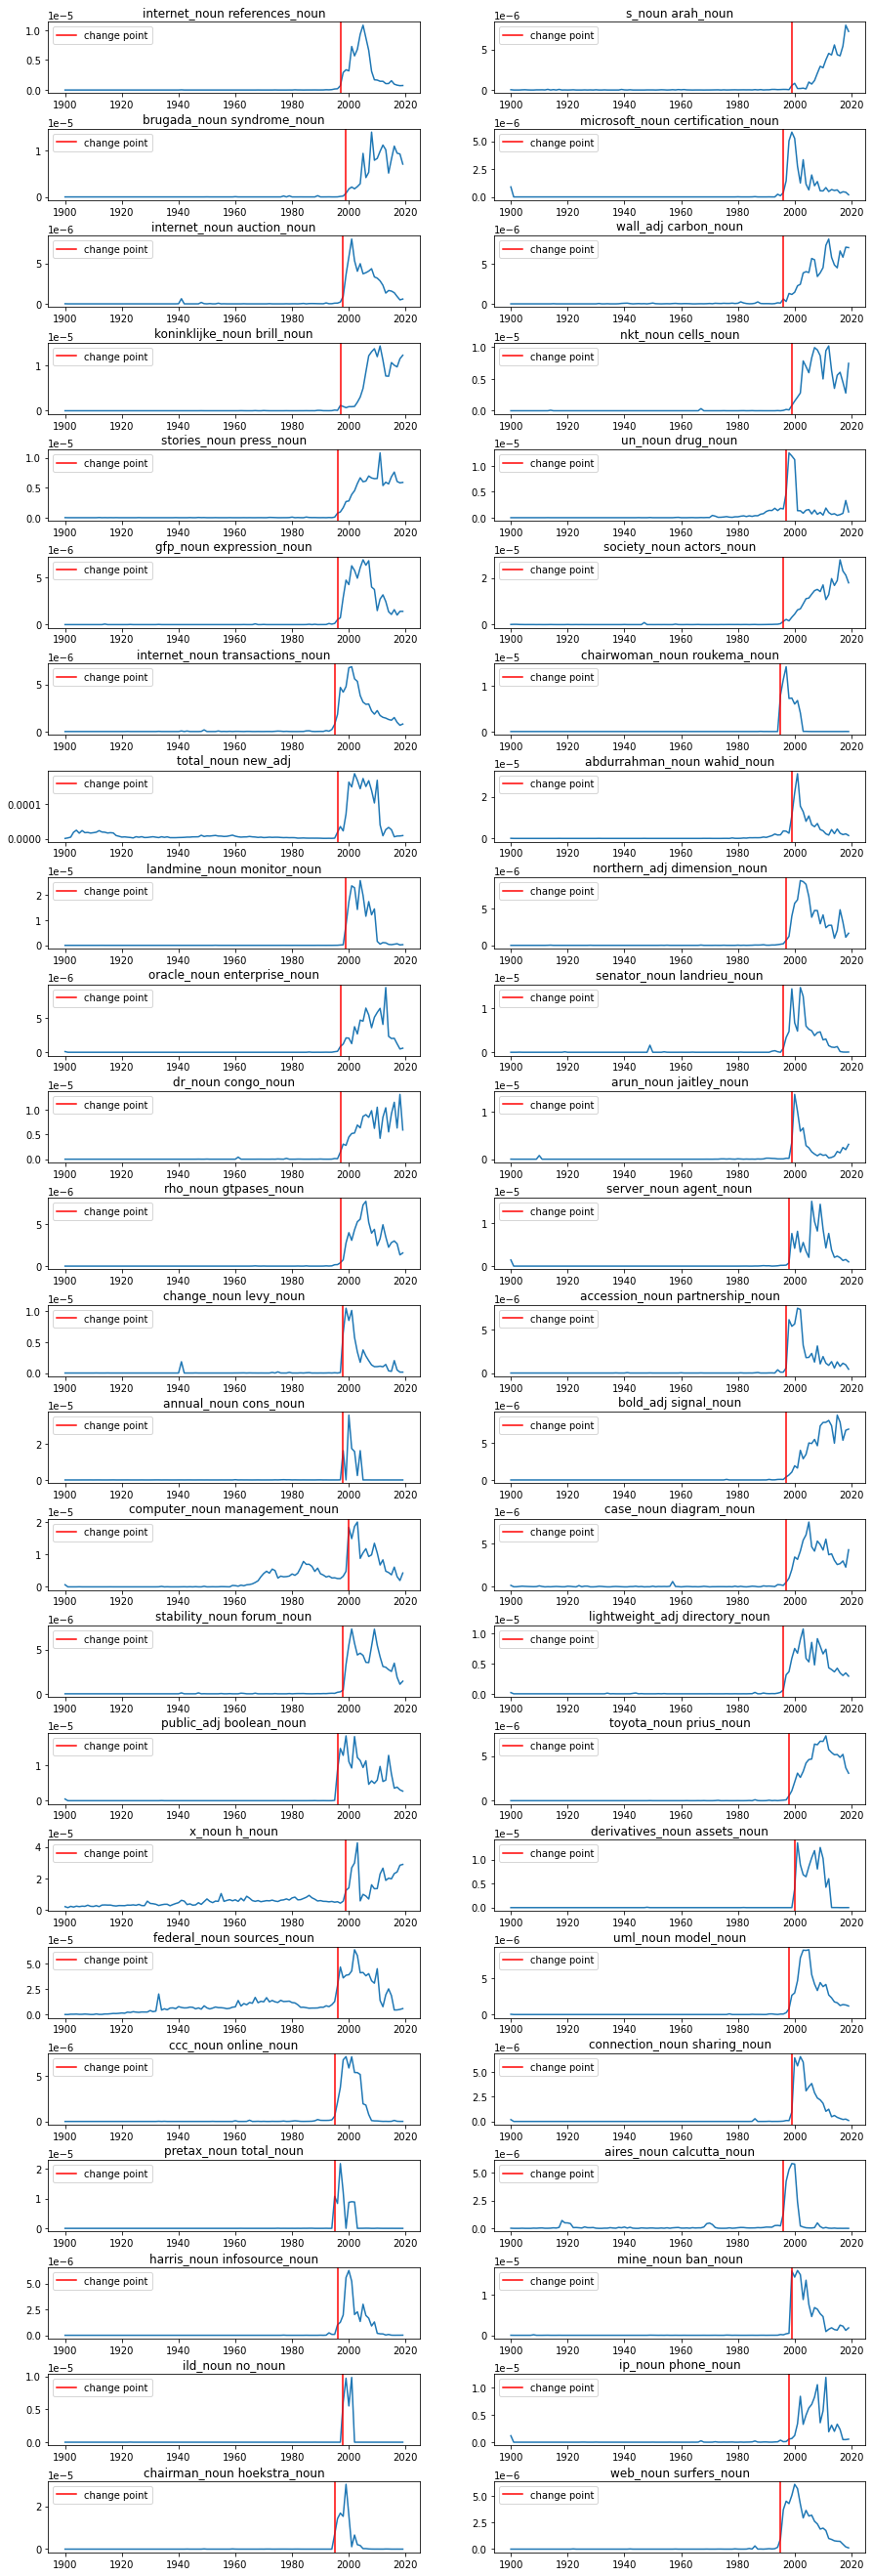

In [25]:
plot_data(pred1Plot)

<Figure size 432x288 with 0 Axes>

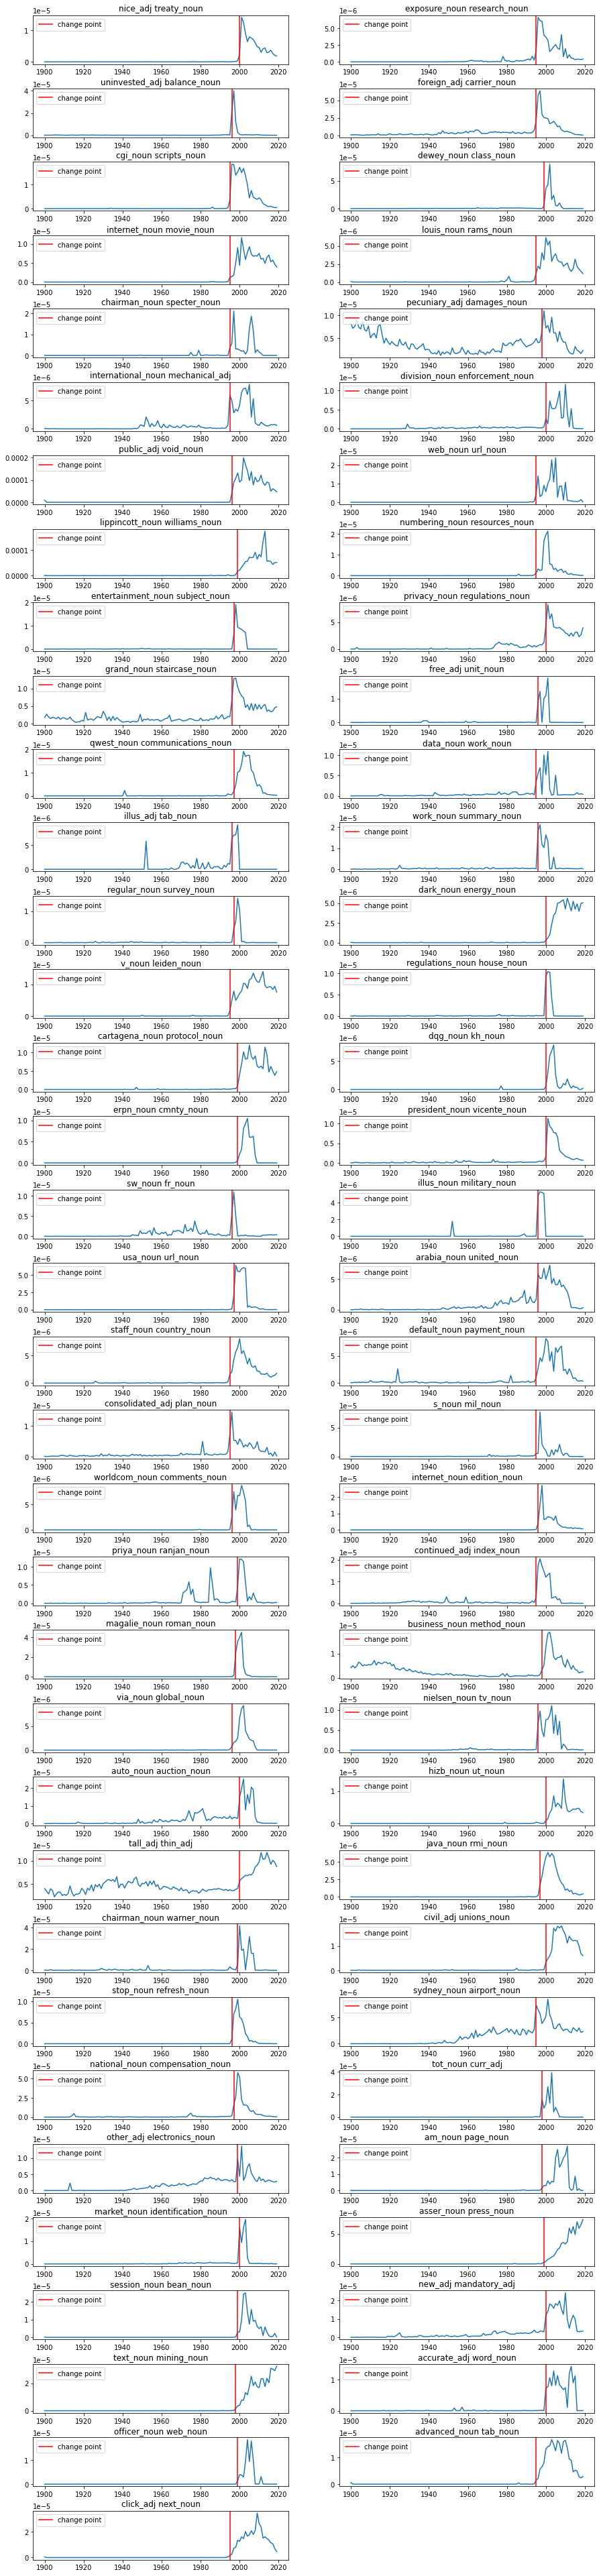

In [26]:
plot_data(pred0Plot)

### Plot specific bigram

In [32]:
# Make a dataframe with the bigrams predicted as mainstream and the bigrams predicted as not mainstream
#plot = joined.where(col('bigram')=='ibm_noun spectrum_noun')
plot = df_allyears.where(col('bigram') == 'html_noun source_noun')

In [33]:
plotpd = plot.toPandas()

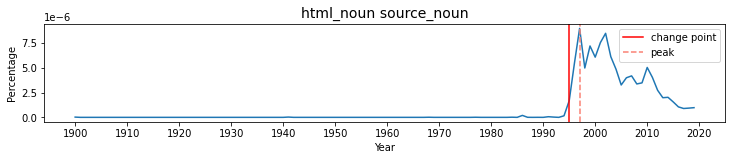

In [35]:
plt.figure(figsize=(12.2,1.8))
plotpd = plotpd.reset_index()
plt.plot(plotpd.bigram_percent.values, label = '_nolegend_')
plt.axvline(x = plotpd.changepoint_year[0]-1900, color='r')
plt.axvline(x = plotpd.peak_year[0]-1900, color='salmon', linestyle='--')    
plt.xlabel('')
plt.ylabel('')
xlabels = np.arange(1900,2021,10)
x = np.arange(0,121,10)
plt.xticks(x, labels=xlabels)
plt.title('html_noun source_noun', fontsize=14)
plt.legend(['change point','peak'])
plt.xlabel('Year', fontsize=10)
plt.ylabel('Percentage', fontsize=10)
plt.savefig('htmlsource', bbox_inches='tight')
plt.show()